In [1]:
# Imports
import torch
import torch.nn as nn
import numpy as np
import random

# Causal_cocycle imports
from causal_cocycle.model_factory import CocycleFactory
from causal_cocycle.model_new import CocycleModel
from causal_cocycle.loss_factory import CocycleLossFactory
from causal_cocycle.optimise_new import validate, optimise
from causal_cocycle.kernels import gaussian_kernel

# Old imports
from causal_cocycle.model import cocycle_model
from causal_cocycle.optimise_loader import optimise as optimise_loader
from causal_cocycle.optimise_loader_old import optimise as optimise_loader_old
from causal_cocycle.optimise import optimise as optimise_old
from causal_cocycle.loss_functions import Loss

# For manual model build
from causal_cocycle.conditioners_new import CompositeConditioner, NNConditioner
from causal_cocycle.transformers_new import Transformer, ShiftLayer
from causal_cocycle.conditioners import NN_RELU_Conditioner, Lin_Conditioner
from causal_cocycle.transformers import Transformer as Transformer_old
from causal_cocycle.transformers import Shift_layer
 

# Import the DGP and policy functions from BD.py
from BD import DGP, policy, new_policy

# Import configs 
from BD_cocycle_config import model_config, opt_config
from BD_dgp_config import dgp_config

import matplotlib.pyplot as plt

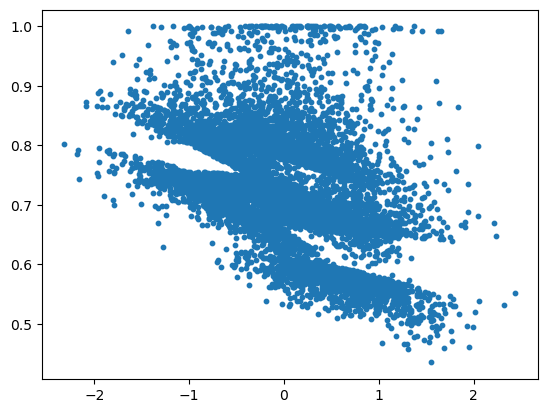

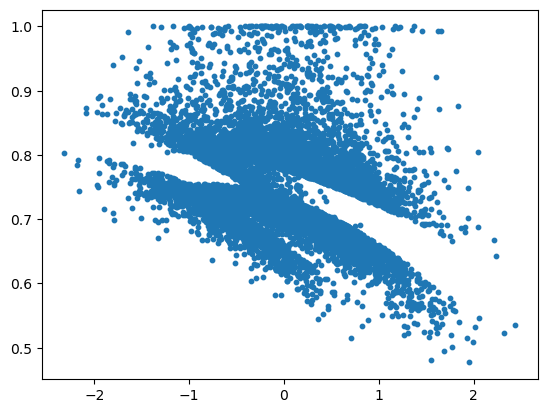

In [2]:
# Generating observatioanl data with configs
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Z,X,Y = DGP(policy = policy,**dgp_config)
plt.scatter(Z @ dgp_config['projection_coeffs'],torch.sigmoid(Y), s = 10);
plt.show()

# Generating interventional data with configs
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Zint,Xint,Yint = DGP(policy = new_policy,**dgp_config)
plt.scatter(Zint @ dgp_config['projection_coeffs'],torch.sigmoid(Yint), s = 10);

# Random dataset shuffle
id = torch.randperm(Z.size(0))
Ztr,Xtr,Ytr = Z[id],X[id],Y[id]

In [3]:
# Model construction
torch.manual_seed(seed)
cond = NNConditioner(
    width=128,
     layers=2,
     input_dims=11,
     output_dims=1,
     bias=True,
     activation=nn.ReLU()
)
conditioner = CompositeConditioner([cond])
transformer = Transformer([ShiftLayer()])
model = CocycleModel(conditioner,transformer)

# Old Model construction
conditioner_old = [cond]
transformer_old = transformer
model_old = cocycle_model(conditioner_old, transformer_old)

In [4]:
# Loss construction
kernel = [gaussian_kernel(torch.ones(1),1)] * 2  # Example: two kernels
loss_factory = CocycleLossFactory(kernel)
loss = loss_factory.build_loss("CMMD_V", X, Y, subsamples=1000)

loss_old =  Loss(loss_fn = "CMMD_V", kernel = loss.kernel)

In [5]:
optimise_loader(model,
             loss,
             Xtr,
             Ytr, 
             loss_val = [],
             inputs_val = [],
             outputs_val = [],
             learn_rate = [1e-3], 
             epochs = 100, 
             weight_decay = 0,
            # optimise_loss_params = True, 
             val_loss = True, 
             val_loss_freq = 100,
             val_tol = 1e-3, 
             batch_size = 64, 
             val_batch_size = 64,
             batch_sampling = "random", 
             scheduler = False, 
             schedule_milestone = 100, 
             n_schedule = 100,
             lr_mult = 0.90, 
             plot = False, 
             plot_start = 30, 
             print_ = True, 
             optimise_conditioners = True, 
             likelihood_param_opt = False,
             likelihood_param_lr = 0.01)

Conditioner 0 has 18177 params
Epoch 1/100, Training Loss: -0.5199
Epoch 2/100, Training Loss: -0.5408
Epoch 3/100, Training Loss: -0.5498
Epoch 4/100, Training Loss: -0.5546


KeyboardInterrupt: 

In [6]:
optimise_loader_old(model_old,
             loss,
             Xtr,
             Ytr, 
             loss_val = [],
             inputs_val = [],
             outputs_val = [],
             learn_rate = [1e-3], 
             epochs = 100, 
             weight_decay = 0,
            # optimise_loss_params = True, 
             val_loss = True, 
             val_loss_freq = 100,
             val_tol = 1e-3, 
             batch_size = 64, 
             val_batch_size = 64,
             batch_sampling = "random", 
             scheduler = False, 
             schedule_milestone = 100, 
             n_schedule = 100,
             lr_mult = 0.90, 
             plot = False, 
             plot_start = 30, 
             print_ = True, 
             optimise_conditioners = True, 
             likelihood_param_opt = False,
             likelihood_param_lr = 0.01)

Conditioner 0 has 18177 params
Epoch 1/100, Training Loss: -0.5609
Epoch 2/100, Training Loss: -0.5650
Epoch 3/100, Training Loss: -0.5671
Epoch 4/100, Training Loss: -0.5685
Epoch 5/100, Training Loss: -0.5699


KeyboardInterrupt: 

In [8]:
optimise(model,
             loss,
             Xtr,
             Ytr, 
             inputs_val=None,
             outputs_val=None,
             learn_rate=1e-3, 
             epochs=100,
             weight_decay=0,
             batch_size=64,
             val_batch_size=64,
             scheduler=False, 
             schedule_milestone=100, 
             lr_mult=0.90, 
             print_=True, 
             plot=False,
             likelihood_param_opt=False,
             likelihood_param_lr=0.01,
             loss_val=None)

AttributeError: 'CompositeConditioner' object has no attribute 'conditioners'

In [9]:
# Model construction
torch.manual_seed(seed)
cond = NNConditioner(
    width=128,
     layers=2,
     input_dims=11,
     output_dims=1,
     bias=True,
     activation=nn.ReLU()
)
conditioner = CompositeConditioner([cond])
transformer = Transformer([ShiftLayer()])
model = CocycleModel(conditioner,transformer)

# Old Model construction
conditioner_old = [cond]
transformer_old = transformer
model_old = cocycle_model(conditioner_old, transformer_old)

In [12]:
# Testing difference in model predictions
x = X[:2]
y = Y[:2]
preds = model.cocycle(x+1,x,y)
preds_old = model_old.cocycle(x+1,x,y)
preds - preds_old

tensor([[0.],
        [0.]], grad_fn=<SubBackward0>)

In [11]:
preds = model.inverse_transformation(x,y)
preds_old = model_old.inverse_transformation(x,y)
preds - preds_old

tensor([[0.],
        [0.]], grad_fn=<SubBackward0>)